# Rectified Flow Text-to-Image Model Training on MS-COCO

Based on: *Scaling Rectified Flow Transformers for High-Resolution Image Synthesis*

This notebook implements:
- Rectified Flow with logit-normal timestep sampling (rf/lognorm(0.00, 1.00))
- Simplified MM-DiT architecture
- Training and validation loops with loss tracking
- FID and CLIP score computation
- Visualization of training progress
- Tunable hyperparameters (epochs, learning rate, batch size)

## Hardware Requirements
- GPU with at least 8GB VRAM recommended
- 16GB+ RAM
- ~20GB disk space for COCO dataset

## 1. Install Required Packages

In [ ]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers diffusers accelerate
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install scipy matplotlib seaborn
!pip install pycocotools
!pip install einops
!pip install pytorch-fid

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pkp4egtu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pkp4egtu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=fe163c905d75ea88ebd25817b4eb44993960486a517eb4498c1a017877a8e34e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ce9t1ocn/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


## 2. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CocoCaptions
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
import os
from pathlib import Path
import json
from scipy import linalg
import clip
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA L4
Memory Available: 23.80 GB


## 3. Hyperparameters (Tunable)

In [ ]:
# ==========================
# TUNABLE HYPERPARAMETERS
# ==========================

# Training parameters
EPOCHS = 40                    # Number of training epochs
LEARNING_RATE = 1e-4          # Learning rate
BATCH_SIZE = 16               # Batch size (reduce if OOM)
SAMPLE_SIZE = 10000           # Number of samples from COCO to use
VAL_SPLIT = 0.1               # Validation split ratio

# Model parameters
IMAGE_SIZE = 128              # Image resolution (64x64 for faster training)
LATENT_DIM = 512              # Latent dimension
TEXT_DIM = 512                # Text embedding dimension
HIDDEN_DIM = 512              # Hidden dimension for transformer
NUM_HEADS = 8                 # Number of attention heads
NUM_LAYERS = 6                # Number of transformer layers
DROPOUT = 0.1                 # Dropout rate

# Rectified Flow parameters (from paper)
RF_LOCATION = 0.0             # Logit-normal location parameter (m)
RF_SCALE = 1.0                # Logit-normal scale parameter (s)

# Training settings
GRADIENT_CLIP = 1.0           # Gradient clipping
WARMUP_STEPS = 1000           # Warmup steps
SAVE_INTERVAL = 5             # Save checkpoint every N epochs
EVAL_INTERVAL = 5             # Evaluate every N epochs
NUM_SAMPLING_STEPS = 50       # Number of steps for sampling
CFG_SCALE = 7.5               # Classifier-free guidance scale

# Paths
DATA_DIR = './data/coco'
CHECKPOINT_DIR = './checkpoints'
RESULTS_DIR = './results'
SAMPLE_DIR = './samples'

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

print("\n=== Configuration ===")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Sample Size: {SAMPLE_SIZE}")
print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Validation Split: {VAL_SPLIT*100}%")


=== Configuration ===
Epochs: 40
Learning Rate: 0.0001
Batch Size: 16
Sample Size: 10000
Image Size: 128x128
Validation Split: 10.0%


## 4. Download and Prepare MS-COCO Dataset

In [ ]:
# Download COCO dataset (this will take some time)
!mkdir -p {DATA_DIR}

# Download training images
if not os.path.exists(f"{DATA_DIR}/train2017"):
    print("Downloading COCO train2017 images...")
    !wget http://images.cocodataset.org/zips/train2017.zip -P {DATA_DIR}
    !unzip -q {DATA_DIR}/train2017.zip -d {DATA_DIR}
    !rm {DATA_DIR}/train2017.zip

# Download validation images
if not os.path.exists(f"{DATA_DIR}/val2017"):
    print("Downloading COCO val2017 images...")
    !wget http://images.cocodataset.org/zips/val2017.zip -P {DATA_DIR}
    !unzip -q {DATA_DIR}/val2017.zip -d {DATA_DIR}
    !rm {DATA_DIR}/val2017.zip

# Download annotations
if not os.path.exists(f"{DATA_DIR}/annotations"):
    print("Downloading COCO annotations...")
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {DATA_DIR}
    !unzip -q {DATA_DIR}/annotations_trainval2017.zip -d {DATA_DIR}
    !rm {DATA_DIR}/annotations_trainval2017.zip

print("\nCOCO dataset ready!")

--2025-12-13 03:05:54--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.61.49, 52.217.72.252, 16.15.187.142, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.61.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘./data/coco/train2017.zip’

train2017.zip       100%[===================>]  18.01G  63.9MB/s    in 5m 36s  

2025-12-13 03:11:31 (54.8 MB/s) - ‘./data/coco/train2017.zip’ saved [19336861798/19336861798]

--2025-12-13 03:13:28--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.132.209, 3.5.27.147, 52.217.114.217, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.132.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘./data/coco/val2017.zip’

val2017.zip  

## 5. Dataset Class

In [ ]:
class COCODataset(Dataset):
    """MS-COCO Dataset for text-to-image training"""

    def __init__(self, root, annFile, transform=None, max_samples=None):
        self.coco = CocoCaptions(root=root, annFile=annFile)
        self.transform = transform

        # Limit dataset size if specified
        if max_samples is not None and max_samples < len(self.coco):
            indices = np.random.choice(len(self.coco), max_samples, replace=False)
            self.indices = indices.tolist()  # Convert to Python list of ints
        else:
            self.indices = list(range(len(self.coco)))  # Python list of ints

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Convert idx to Python int to avoid numpy.int64 issues
        idx = int(idx)
        actual_idx = int(self.indices[idx])  # Ensure Python int
        image, captions = self.coco[actual_idx]

        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Randomly select one caption
        caption = captions[np.random.randint(len(captions))]

        return image, caption


# Define transforms
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

print("Dataset class defined!")

Dataset class defined!


## 6. Rectified Flow Scheduler

In [ ]:
class RectifiedFlowScheduler:
    """
    Implements Rectified Flow with logit-normal timestep sampling
    as described in the paper (Section 3.1)

    Forward process: z_t = (1-t)*x_0 + t*epsilon
    where epsilon ~ N(0, I)
    """

    def __init__(self, m=0.0, s=1.0):
        """
        Args:
            m: location parameter for logit-normal distribution
            s: scale parameter for logit-normal distribution
        """
        self.m = m
        self.s = s

    def sample_timesteps(self, batch_size, device):
        """Sample timesteps using logit-normal distribution"""
        # Sample from normal distribution
        u = torch.randn(batch_size, device=device) * self.s + self.m
        # Apply logistic function to get t in [0, 1]
        t = torch.sigmoid(u)
        return t

    def add_noise(self, x_0, t, noise=None):
        """
        Forward process: z_t = (1-t)*x_0 + t*epsilon

        Args:
            x_0: clean images [B, C, H, W]
            t: timesteps [B]
            noise: optional noise tensor

        Returns:
            z_t: noised images
            noise: the noise that was added
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        # Reshape t for broadcasting
        t = t.view(-1, 1, 1, 1)

        # Straight line interpolation
        z_t = (1 - t) * x_0 + t * noise

        return z_t, noise

    def get_velocity_target(self, x_0, noise, t):
        """
        Compute the velocity prediction target: v = noise - x_0

        This is derived from d/dt(z_t) = -x_0 + noise
        """
        return noise - x_0

    def sample(self, model, text_embeddings, shape, num_steps=50, cfg_scale=7.5, device='cuda'):
        """
        Sample from the model using Euler method

        Args:
            model: the denoising model
            text_embeddings: text conditioning [B, seq_len, dim]
            shape: shape of images to generate [B, C, H, W]
            num_steps: number of sampling steps
            cfg_scale: classifier-free guidance scale
            device: device to run on

        Returns:
            x_0: generated images
        """
        batch_size = shape[0]

        # Start from pure noise (t=1)
        z_t = torch.randn(shape, device=device)

        # Time steps from 1 to 0
        timesteps = torch.linspace(1, 0, num_steps + 1, device=device)
        dt = 1.0 / num_steps

        model.eval()
        with torch.no_grad():
            for i in range(num_steps):
                t = timesteps[i]
                t_batch = torch.full((batch_size,), t, device=device)

                # Predict velocity with conditioning
                v_cond = model(z_t, t_batch, text_embeddings)

                if cfg_scale > 1.0:
                    # Predict velocity without conditioning (unconditional)
                    uncond_embeddings = torch.zeros_like(text_embeddings)
                    v_uncond = model(z_t, t_batch, uncond_embeddings)

                    # Classifier-free guidance
                    v = v_uncond + cfg_scale * (v_cond - v_uncond)
                else:
                    v = v_cond

                # Euler step: z_{t-dt} = z_t - dt * v
                z_t = z_t - dt * v

        model.train()
        return z_t


# Initialize scheduler
scheduler = RectifiedFlowScheduler(m=RF_LOCATION, s=RF_SCALE)
print("Rectified Flow Scheduler initialized!")
print(f"Using logit-normal sampling with m={RF_LOCATION}, s={RF_SCALE}")

Rectified Flow Scheduler initialized!
Using logit-normal sampling with m=0.0, s=1.0


## 7. Model Architecture

Simplified MM-DiT (Multimodal Diffusion Transformer) based on the paper

In [ ]:
"""
MM-DiT (Multi-Modal Diffusion Transformer) Architecture
Based on "Scaling Rectified Flow Transformers for High-Resolution Image Synthesis"
(Stability AI, 2024)

Key features:
1. Separate weight streams for text and image modalities
2. Joint attention where modalities interact
3. Modality-specific LayerNorm and MLP
4. QK-Normalization for training stability (optional)
"""

import torch
import torch.nn as nn
import numpy as np
import math


class SinusoidalPositionEmbedding(nn.Module):
    """Sinusoidal position embedding for timesteps"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


class RMSNorm(nn.Module):
    """
    RMS Normalization for Q and K in attention (Section 5.3.2)
    Helps stabilize training at high resolutions
    """
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        norm = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * norm * self.scale


class JointAttention(nn.Module):
    """
    Joint Multi-Head Attention for MM-DiT

    Concatenates text and image tokens for attention,
    allowing bidirectional information flow between modalities.
    """

    def __init__(self, dim, num_heads=8, qkv_bias=True, use_qk_norm=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Separate Q, K, V projections for text and image
        self.q_text = nn.Linear(dim, dim, bias=qkv_bias)
        self.k_text = nn.Linear(dim, dim, bias=qkv_bias)
        self.v_text = nn.Linear(dim, dim, bias=qkv_bias)

        self.q_image = nn.Linear(dim, dim, bias=qkv_bias)
        self.k_image = nn.Linear(dim, dim, bias=qkv_bias)
        self.v_image = nn.Linear(dim, dim, bias=qkv_bias)

        # Optional QK normalization (for stability at high res)
        self.use_qk_norm = use_qk_norm
        if use_qk_norm:
            self.q_norm = RMSNorm(self.head_dim)
            self.k_norm = RMSNorm(self.head_dim)

        # Output projections
        self.proj_text = nn.Linear(dim, dim)
        self.proj_image = nn.Linear(dim, dim)

    def forward(self, text, image):
        """
        Args:
            text: [B, N_text, dim]
            image: [B, N_image, dim]
        Returns:
            text_out: [B, N_text, dim]
            image_out: [B, N_image, dim]
        """
        B, N_text, C = text.shape
        N_image = image.shape[1]

        # Generate Q, K, V for both modalities
        q_text = self.q_text(text).reshape(B, N_text, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k_text = self.k_text(text).reshape(B, N_text, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v_text = self.v_text(text).reshape(B, N_text, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        q_image = self.q_image(image).reshape(B, N_image, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k_image = self.k_image(image).reshape(B, N_image, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v_image = self.v_image(image).reshape(B, N_image, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Optional QK normalization
        if self.use_qk_norm:
            q_text = self.q_norm(q_text)
            k_text = self.k_norm(k_text)
            q_image = self.q_norm(q_image)
            k_image = self.k_norm(k_image)

        # Concatenate for joint attention
        # [B, num_heads, N_text + N_image, head_dim]
        q = torch.cat([q_text, q_image], dim=2)
        k = torch.cat([k_text, k_image], dim=2)
        v = torch.cat([v_text, v_image], dim=2)

        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        # Apply attention
        out = (attn @ v)  # [B, num_heads, N_text + N_image, head_dim]

        # Split back to text and image
        out_text = out[:, :, :N_text, :].transpose(1, 2).reshape(B, N_text, C)
        out_image = out[:, :, N_text:, :].transpose(1, 2).reshape(B, N_image, C)

        # Project
        out_text = self.proj_text(out_text)
        out_image = self.proj_image(out_image)

        return out_text, out_image


class FeedForward(nn.Module):
    """Feed-forward network with GELU activation"""

    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        return self.dropout(self.net(x))


class MMDiTBlock(nn.Module):
    """
    MM-DiT Block with separate processing streams for text and image

    Based on Figure 2b from the paper:
    - Separate LayerNorm for text and image
    - Separate modulation parameters (α, β, γ, δ, ε, ζ) for each modality
    - Joint attention where text and image interact
    - Separate MLP for each modality
    """

    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.0, use_qk_norm=False):
        super().__init__()

        # Text stream
        self.norm1_text = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.norm2_text = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.mlp_text = FeedForward(dim, int(dim * mlp_ratio), dropout)

        # Image stream
        self.norm1_image = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.norm2_image = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.mlp_image = FeedForward(dim, int(dim * mlp_ratio), dropout)

        # Joint attention
        self.attn = JointAttention(dim, num_heads, use_qk_norm=use_qk_norm)

        # Adaptive layer norm (modulation) for text
        # Produces: scale_attn, shift_attn, gate_attn, scale_mlp, shift_mlp, gate_mlp
        self.adaLN_text = nn.Sequential(
            nn.SiLU(),
            nn.Linear(dim, 6 * dim, bias=True)
        )

        # Adaptive layer norm (modulation) for image
        self.adaLN_image = nn.Sequential(
            nn.SiLU(),
            nn.Linear(dim, 6 * dim, bias=True)
        )

    def forward(self, text, image, t_emb):
        """
        Args:
            text: [B, N_text, dim]
            image: [B, N_image, dim]
            t_emb: [B, dim] - timestep embedding
        Returns:
            text: [B, N_text, dim]
            image: [B, N_image, dim]
        """
        # Get modulation parameters for text
        ada_text = self.adaLN_text(t_emb)  # [B, 6*dim]
        shift_msa_t, scale_msa_t, gate_msa_t, shift_mlp_t, scale_mlp_t, gate_mlp_t = ada_text.chunk(6, dim=1)

        # Get modulation parameters for image
        ada_image = self.adaLN_image(t_emb)  # [B, 6*dim]
        shift_msa_i, scale_msa_i, gate_msa_i, shift_mlp_i, scale_mlp_i, gate_mlp_i = ada_image.chunk(6, dim=1)

        # Add dimensions for broadcasting: [B, 1, dim]
        shift_msa_t = shift_msa_t.unsqueeze(1)
        scale_msa_t = scale_msa_t.unsqueeze(1)
        gate_msa_t = gate_msa_t.unsqueeze(1)
        shift_mlp_t = shift_mlp_t.unsqueeze(1)
        scale_mlp_t = scale_mlp_t.unsqueeze(1)
        gate_mlp_t = gate_mlp_t.unsqueeze(1)

        shift_msa_i = shift_msa_i.unsqueeze(1)
        scale_msa_i = scale_msa_i.unsqueeze(1)
        gate_msa_i = gate_msa_i.unsqueeze(1)
        shift_mlp_i = shift_mlp_i.unsqueeze(1)
        scale_mlp_i = scale_mlp_i.unsqueeze(1)
        gate_mlp_i = gate_mlp_i.unsqueeze(1)

        # Attention block with modulation
        # Text: modulate -> norm -> attention
        text_normed = self.norm1_text(text) * (1 + scale_msa_t) + shift_msa_t
        image_normed = self.norm1_image(image) * (1 + scale_msa_i) + shift_msa_i

        # Joint attention
        attn_text, attn_image = self.attn(text_normed, image_normed)

        # Apply gate and residual
        text = text + gate_msa_t * attn_text
        image = image + gate_msa_i * attn_image

        # MLP block with modulation
        # Text: modulate -> norm -> MLP
        text_normed = self.norm2_text(text) * (1 + scale_mlp_t) + shift_mlp_t
        image_normed = self.norm2_image(image) * (1 + scale_mlp_i) + shift_mlp_i

        # Apply MLP
        text = text + gate_mlp_t * self.mlp_text(text_normed)
        image = image + gate_mlp_i * self.mlp_image(image_normed)

        return text, image


class MMDiT(nn.Module):
    """
    Multi-Modal Diffusion Transformer (MM-DiT)

    Implements the architecture from:
    "Scaling Rectified Flow Transformers for High-Resolution Image Synthesis"

    Key features:
    - Separate processing streams for text and image tokens
    - Bidirectional information flow via joint attention
    - Timestep conditioning via adaptive layer norm (adaLN)
    - Optional QK normalization for training stability
    """

    def __init__(
        self,
        image_size=128,
        patch_size=4,
        in_channels=3,
        hidden_dim=512,
        depth=6,
        num_heads=8,
        text_dim=512,
        mlp_ratio=4.0,
        dropout=0.0,
        use_qk_norm=False
    ):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        self.num_patches = (image_size // patch_size) ** 2

        # === Image Processing ===
        # Patchify: convert image to patches
        self.patch_embed = nn.Conv2d(
            in_channels, hidden_dim,
            kernel_size=patch_size, stride=patch_size
        )

        # 2D positional embeddings for image patches
        self.pos_embed_image = nn.Parameter(torch.zeros(1, self.num_patches, hidden_dim))

        # === Text Processing ===
        # Project text embeddings to hidden_dim
        self.text_proj = nn.Linear(text_dim, hidden_dim)

        # === Timestep Embedding ===
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedding(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # === MM-DiT Blocks ===
        self.blocks = nn.ModuleList([
            MMDiTBlock(hidden_dim, num_heads, mlp_ratio, dropout, use_qk_norm)
            for _ in range(depth)
        ])

        # === Output ===
        # Final layer norm for image stream
        self.final_norm = nn.LayerNorm(hidden_dim, elementwise_affine=False, eps=1e-6)

        # Adaptive layer norm for final layer
        self.adaLN_final = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_dim, 2 * hidden_dim, bias=True)
        )

        # Output projection: patches -> image
        self.final_linear = nn.Linear(hidden_dim, patch_size * patch_size * in_channels)

        # Initialize weights
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize patch embedding like nn.Linear
        w = self.patch_embed.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.patch_embed.bias, 0)

        # Initialize position embeddings
        nn.init.normal_(self.pos_embed_image, std=0.02)

        # Initialize timestep embedding MLP
        nn.init.normal_(self.time_embed[1].weight, std=0.02)
        nn.init.normal_(self.time_embed[3].weight, std=0.02)

        # Zero-out adaLN modulation layers
        for block in self.blocks:
            nn.init.constant_(block.adaLN_text[-1].weight, 0)
            nn.init.constant_(block.adaLN_text[-1].bias, 0)
            nn.init.constant_(block.adaLN_image[-1].weight, 0)
            nn.init.constant_(block.adaLN_image[-1].bias, 0)

        nn.init.constant_(self.adaLN_final[-1].weight, 0)
        nn.init.constant_(self.adaLN_final[-1].bias, 0)

        # Zero-out output layer
        nn.init.constant_(self.final_linear.weight, 0)
        nn.init.constant_(self.final_linear.bias, 0)

    def patchify(self, x):
        """
        Convert images to patches
        x: [B, C, H, W]
        returns: [B, num_patches, hidden_dim]
        """
        B, C, H, W = x.shape
        x = self.patch_embed(x)  # [B, hidden_dim, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, hidden_dim]
        return x

    def unpatchify(self, x):
        """
        Convert patches back to images
        x: [B, num_patches, patch_size^2 * C]
        returns: [B, C, H, W]
        """
        B = x.shape[0]
        h = w = int(self.num_patches ** 0.5)
        p = self.patch_size
        c = self.in_channels

        x = x.reshape(B, h, w, p, p, c)
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()  # [B, C, h, p, w, p]
        x = x.reshape(B, c, h * p, w * p)
        return x

    def forward(self, x, t, text_embeddings, text_mask=None):
        """
        Forward pass

        Args:
            x: noised images [B, C, H, W]
            t: timesteps [B]
            text_embeddings: text embeddings [B, seq_len, text_dim]
            text_mask: optional text mask [B, seq_len]

        Returns:
            predicted velocity [B, C, H, W]
        """
        B = x.shape[0]

        # === Process Image ===
        image = self.patchify(x)  # [B, num_patches, hidden_dim]
        image = image + self.pos_embed_image  # Add positional embeddings

        # === Process Text ===
        text = self.text_proj(text_embeddings)  # [B, seq_len, hidden_dim]

        # === Timestep Embedding ===
        t_emb = self.time_embed(t)  # [B, hidden_dim]

        # === Process through MM-DiT Blocks ===
        for block in self.blocks:
            text, image = block(text, image, t_emb)

        # === Final Processing (Image Only) ===
        # Get final adaLN parameters
        ada_final = self.adaLN_final(t_emb)  # [B, 2*hidden_dim]
        shift, scale = ada_final.chunk(2, dim=1)
        shift = shift.unsqueeze(1)  # [B, 1, hidden_dim]
        scale = scale.unsqueeze(1)  # [B, 1, hidden_dim]

        # Apply final modulation and norm
        image = self.final_norm(image) * (1 + scale) + shift

        # Project to output
        image = self.final_linear(image)  # [B, num_patches, p^2 * C]

        # Unpatchify to image
        output = self.unpatchify(image)  # [B, C, H, W]

        return output


if __name__ == "__main__":
    # Test the model
    print("Testing MM-DiT architecture...")

    model = MMDiT(
        image_size=128,
        patch_size=4,
        in_channels=3,
        hidden_dim=512,
        depth=6,
        num_heads=8,
        text_dim=512,
        use_qk_norm=True
    )

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Test forward pass
    B = 2
    x = torch.randn(B, 3, 128, 128)
    t = torch.rand(B)
    text = torch.randn(B, 77, 512)

    output = model(x, t, text)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print("\n✅ MM-DiT architecture test passed!")


Model architecture defined!


## 8. Text Encoder (CLIP)

In [ ]:
# Load CLIP for text encoding
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
clip_model = clip_model.float()  # ADD THIS LINE

def encode_text(texts, max_length=77):
    """
    Encode text using CLIP

    Args:
        texts: list of strings
        max_length: maximum sequence length

    Returns:
        text embeddings [B, seq_len, dim]
    """
    # Tokenize
    tokens = clip.tokenize(texts, truncate=True).to(device)

    # Encode with CLIP
    with torch.no_grad():
        # Get text features from CLIP
        text_features = clip_model.encode_text(tokens)

    # Expand to sequence
    # CLIP gives us pooled features, we'll repeat them to create a sequence
    text_features = text_features.unsqueeze(1).repeat(1, max_length, 1)

    # Ensure float32
    text_features = text_features.float()  # ADD THIS LINE

    return text_features

print("CLIP text encoder loaded!")

100%|███████████████████████████████████████| 338M/338M [00:14<00:00, 23.8MiB/s]


CLIP text encoder loaded!


## 9. Evaluation Metrics (FID and CLIP Score)

In [ ]:
class InceptionV3ForFID(nn.Module):
    """Inception V3 for FID computation"""

    def __init__(self):
        super().__init__()
        inception = models.inception_v3(pretrained=True, transform_input=False)
        self.blocks = nn.ModuleList([
            nn.Sequential(*list(inception.children())[:3]),
            nn.Sequential(*list(inception.children())[3:5]),
            nn.Sequential(*list(inception.children())[5:7]),
            nn.Sequential(*list(inception.children())[7:12]),
        ])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for param in self.parameters():
            param.requires_grad = False

        self.eval()

    def forward(self, x):
        # Resize if needed
        if x.shape[2] != 299 or x.shape[3] != 299:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        for block in self.blocks:
            x = block(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x


def calculate_fid(real_features, fake_features):
    """
    Calculate Fréchet Inception Distance

    Args:
        real_features: features from real images [N, dim]
        fake_features: features from generated images [N, dim]

    Returns:
        FID score (lower is better)
    """
    # Calculate mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Calculate squared difference of means
    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * 1e-6
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


def calculate_clip_score(images, texts, clip_model):
    """
    Calculate CLIP score between images and texts

    Args:
        images: tensor of images [B, C, H, W] in [-1, 1]
        texts: list of text strings
        clip_model: CLIP model

    Returns:
        CLIP score (higher is better)
    """
    # Preprocess images for CLIP
    images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
    images = (images + 1) / 2  # Convert from [-1, 1] to [0, 1]

    # Normalize for CLIP
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1).to(images.device)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1).to(images.device)
    images = (images - mean) / std

    # Encode
    with torch.no_grad():
        image_features = clip_model.encode_image(images)
        text_tokens = clip.tokenize(texts, truncate=True).to(images.device)
        text_features = clip_model.encode_text(text_tokens)

        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity
        similarity = (image_features * text_features).sum(dim=-1)

    return similarity.mean().item()


# Initialize Inception model for FID
inception_model = InceptionV3ForFID().to(device)
print("Evaluation metrics ready!")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 232MB/s] 


Evaluation metrics ready!


## 10. Load Dataset and Create DataLoaders

Loading COCO dataset...
loading annotations into memory...
Done (t=0.93s)
creating index...
index created!

Dataset loaded!
Train samples: 9000
Validation samples: 1000
Train batches: 563
Val batches: 63


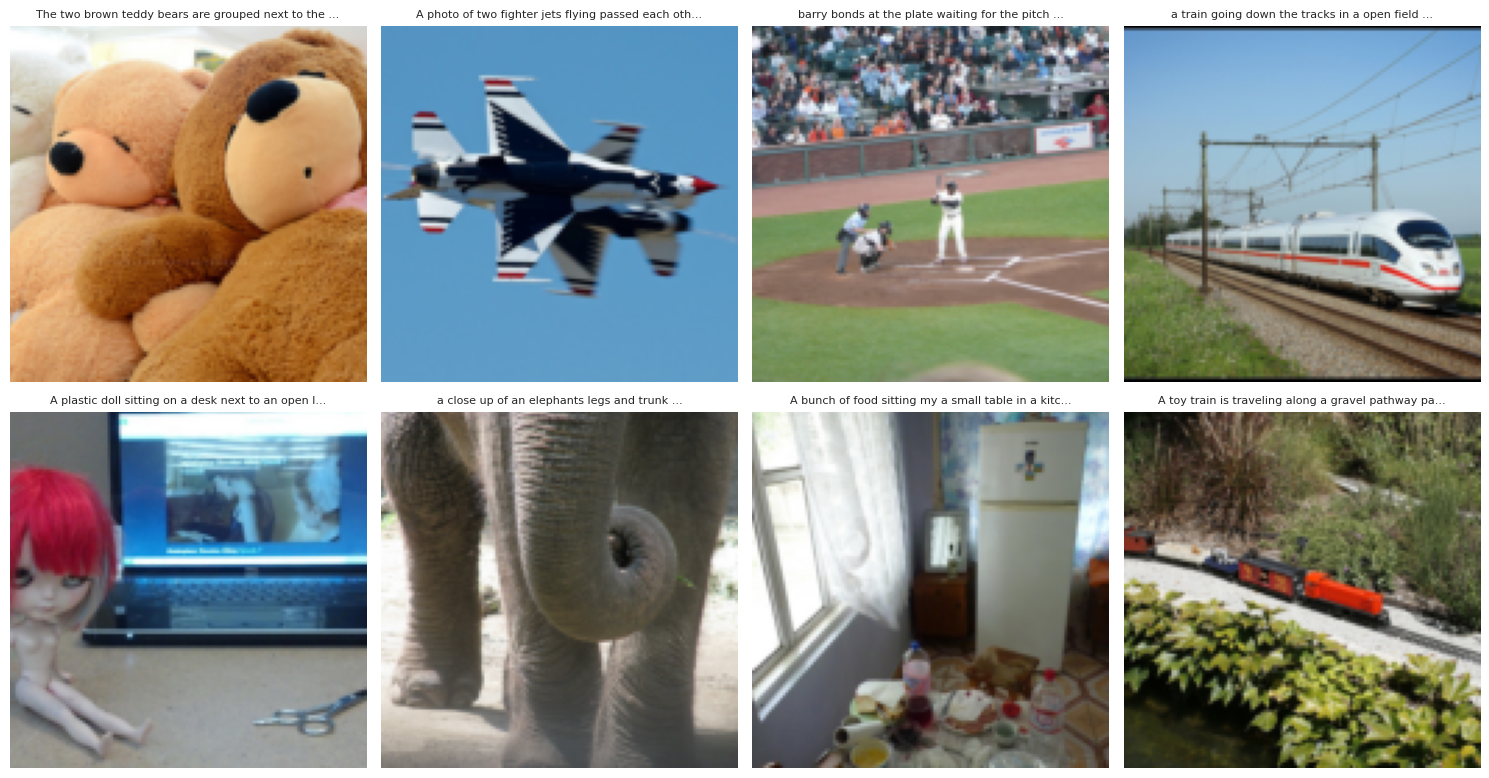


Sample images saved to ./results/dataset_samples.png


In [ ]:
# Create full dataset
print("Loading COCO dataset...")
full_dataset = COCODataset(
    root=f"{DATA_DIR}/train2017",
    annFile=f"{DATA_DIR}/annotations/captions_train2017.json",
    transform=train_transform,
    max_samples=SAMPLE_SIZE
)

# Split into train and validation
val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"\nDataset loaded!")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Visualize some samples
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    if i < len(train_dataset):
        # Get sample - use int() to convert numpy.int64 to Python int
        idx = int(train_dataset.indices[i])  # Convert to Python int
        img, caption = full_dataset[idx]  # Access from full_dataset directly
        img = (img + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
        img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(caption[:50] + '...', fontsize=8)
        ax.axis('off')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/dataset_samples.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"\nSample images saved to {RESULTS_DIR}/dataset_samples.png")

In [ ]:
# Disable automatic mixed precision to avoid dtype issues
torch.backends.cudnn.allow_tf32 = False
torch.backends.cuda.matmul.allow_tf32 = False
print("Disabled TF32 for dtype consistency")

Disabled TF32 for dtype consistency


## 11. Initialize Model and Optimizer

In [ ]:
# Initialize model
model = MMDiT(
    image_size=IMAGE_SIZE,
    patch_size=4,
    in_channels=3,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    text_dim=TEXT_DIM,
    dropout=DROPOUT
).to(device)

# IMPORTANT: Set to float32 to avoid dtype mismatches
model = model.float()

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel initialized!")
print(f"Number of parameters: {num_params:,}")
print(f"Model size: ~{num_params * 4 / 1e6:.2f} MB (FP32)")
print(f"Model dtype: {next(model.parameters()).dtype}")

# Initialize optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Learning rate scheduler with warmup
def get_lr_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        return max(0.1, (total_steps - step) / (total_steps - warmup_steps))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

total_steps = len(train_loader) * EPOCHS
scheduler = get_lr_scheduler(optimizer, WARMUP_STEPS, total_steps)

print(f"Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")


Model initialized!
Number of parameters: 58,102,832
Model size: ~232.41 MB (FP32)
Model dtype: torch.float32
Optimizer: AdamW (lr=0.0001)
Total training steps: 22520
Warmup steps: 1000


## 12. Training and Validation Functions

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, scheduler_rf, epoch):
    """
    Train for one epoch

    Returns:
        avg_loss: average loss for the epoch
    """
    model.train()
    total_loss = 0
    num_batches = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")

    for batch_idx, (images, captions) in enumerate(pbar):
        images = images.to(device)

        # Encode text
        text_embeddings = encode_text(captions)

        # Sample timesteps using logit-normal distribution
        t = scheduler_rf.sample_timesteps(images.shape[0], device)

        # Add noise
        noise = torch.randn_like(images)
        z_t, noise = scheduler_rf.add_noise(images, t, noise)

        # Get velocity target
        v_target = scheduler_rf.get_velocity_target(images, noise, t)

        # Predict velocity
        v_pred = model(z_t, t, text_embeddings)

        # Compute loss (MSE)
        loss = F.mse_loss(v_pred, v_target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)

        optimizer.step()
        scheduler.step()

        # Update metrics
        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'avg_loss': f"{total_loss/num_batches:.4f}",
            'lr': f"{scheduler.get_last_lr()[0]:.6f}"
        })

    return total_loss / num_batches


def validate(model, dataloader, scheduler_rf, epoch):
    """
    Validate the model

    Returns:
        avg_loss: average validation loss
    """
    model.eval()
    total_loss = 0
    num_batches = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")

    with torch.no_grad():
        for images, captions in pbar:
            images = images.to(device)

            # Encode text
            text_embeddings = encode_text(captions)

            # Sample timesteps
            t = scheduler_rf.sample_timesteps(images.shape[0], device)

            # Add noise
            noise = torch.randn_like(images)
            z_t, noise = scheduler_rf.add_noise(images, t, noise)

            # Get velocity target
            v_target = scheduler_rf.get_velocity_target(images, noise, t)

            # Predict velocity
            v_pred = model(z_t, t, text_embeddings)

            # Compute loss
            loss = F.mse_loss(v_pred, v_target)

            total_loss += loss.item()
            num_batches += 1

            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'avg_loss': f"{total_loss/num_batches:.4f}"})

    return total_loss / num_batches


def generate_samples(model, scheduler_rf, prompts, num_samples=4, save_path=None):
    """
    Generate sample images from text prompts

    Args:
        model: the model
        scheduler_rf: rectified flow scheduler
        prompts: list of text prompts
        num_samples: number of samples per prompt
        save_path: path to save the samples

    Returns:
        generated images [B, C, H, W]
    """
    model.eval()

    # Prepare prompts
    all_prompts = prompts * num_samples
    text_embeddings = encode_text(all_prompts)

    # Generate
    shape = (len(all_prompts), 3, IMAGE_SIZE, IMAGE_SIZE)
    samples = scheduler_rf.sample(
        model, text_embeddings, shape,
        num_steps=NUM_SAMPLING_STEPS,
        cfg_scale=CFG_SCALE,
        device=device
    )

    # Visualize
    if save_path:
        fig, axes = plt.subplots(len(prompts), num_samples, figsize=(num_samples*3, len(prompts)*3))
        if len(prompts) == 1:
            axes = axes[np.newaxis, :]

        for i, prompt in enumerate(prompts):
            for j in range(num_samples):
                idx = i * num_samples + j
                img = samples[idx]
                img = (img + 1) / 2  # Denormalize
                img = img.cpu().permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)

                axes[i, j].imshow(img)
                if j == 0:
                    axes[i, j].set_ylabel(prompt[:30] + '...', fontsize=8)
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()

    return samples


def compute_metrics(model, scheduler_rf, val_loader, inception_model, clip_model, num_samples=500):
    """
    Compute FID and CLIP scores

    Args:
        model: the model
        scheduler_rf: rectified flow scheduler
        val_loader: validation dataloader
        inception_model: Inception model for FID
        clip_model: CLIP model for CLIP score
        num_samples: number of samples to evaluate

    Returns:
        fid_score, clip_score
    """
    model.eval()

    # Collect real and fake features
    real_features = []
    fake_features = []
    clip_scores = []

    num_batches = min(num_samples // BATCH_SIZE, len(val_loader))

    print(f"\nComputing metrics on {num_batches * BATCH_SIZE} samples...")
    pbar = tqdm(range(num_batches), desc="Computing metrics")

    with torch.no_grad():
        for i, (real_images, captions) in enumerate(val_loader):
            if i >= num_batches:
                break

            real_images = real_images.to(device)

            # Get real features
            real_feat = inception_model(real_images)
            real_features.append(real_feat.cpu().numpy())

            # Generate fake images
            text_embeddings = encode_text(captions)
            shape = (len(captions), 3, IMAGE_SIZE, IMAGE_SIZE)
            fake_images = scheduler_rf.sample(
                model, text_embeddings, shape,
                num_steps=NUM_SAMPLING_STEPS,
                cfg_scale=CFG_SCALE,
                device=device
            )

            # Get fake features
            fake_feat = inception_model(fake_images)
            fake_features.append(fake_feat.cpu().numpy())

            # Compute CLIP score
            clip_score = calculate_clip_score(fake_images, captions, clip_model)
            clip_scores.append(clip_score)

            pbar.update(1)

    # Concatenate features
    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)

    # Compute FID
    fid_score = calculate_fid(real_features, fake_features)

    # Average CLIP score
    clip_score = np.mean(clip_scores)

    return fid_score, clip_score


print("Training functions defined!")

Training functions defined!


In [ ]:
# Verify all dtypes are consistent
print("Checking model dtypes...")
print(f"Model dtype: {next(model.parameters()).dtype}")
print(f"CLIP dtype: {next(clip_model.parameters()).dtype}")

# Test forward pass
test_img = torch.randn(2, 3, IMAGE_SIZE, IMAGE_SIZE).to(device).float()
test_t = torch.rand(2).to(device).float()
test_text = encode_text(["test prompt", "another test"])
print(f"Test image dtype: {test_img.dtype}")
print(f"Test text dtype: {test_text.dtype}")

try:
    with torch.no_grad():
        test_out = model(test_img, test_t, test_text)
    print(f"Test output dtype: {test_out.dtype}")
    print("✓ All dtypes consistent! Ready to train.")
except Exception as e:
    print(f"✗ Error: {e}")
    print("Fix dtypes before training!")

Checking model dtypes...
Model dtype: torch.float32
CLIP dtype: torch.float32
Test image dtype: torch.float32
Test text dtype: torch.float32
Test output dtype: torch.float32
✓ All dtypes consistent! Ready to train.


In [ ]:
def plot_training_curves(history):
    """
    Plot training curves with separate axes for train/val and smoothing
    """
    from scipy.ndimage import gaussian_filter1d

    # Create figure with 2 rows, 3 columns
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    epochs = np.array(history['epochs'])
    train_loss = np.array(history['train_loss'])
    val_loss = np.array(history['val_loss'])

    # ============================================================
    # Row 1: Original curves with dual y-axes
    # ============================================================

    # Loss plot with dual y-axes
    ax1 = fig.add_subplot(gs[0, 0])
    ax1_twin = ax1.twinx()

    # Plot train loss on left axis
    line1 = ax1.plot(epochs, train_loss, label='Train Loss',
                     marker='o', linewidth=2, color='#2E86AB', alpha=0.7)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Train Loss', fontsize=12, color='#2E86AB')
    ax1.tick_params(axis='y', labelcolor='#2E86AB')
    ax1.grid(True, alpha=0.3)

    # Plot val loss on right axis
    line2 = ax1_twin.plot(epochs, val_loss, label='Val Loss',
                          marker='s', linewidth=2, color='#A23B72', alpha=0.7)
    ax1_twin.set_ylabel('Val Loss', fontsize=12, color='#A23B72')
    ax1_twin.tick_params(axis='y', labelcolor='#A23B72')

    ax1.set_title('Training vs Validation Loss\n(Dual Axes)', fontsize=14, fontweight='bold')

    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right', fontsize=10)

    # FID Score
    fid_epochs = np.array([e for e, f in zip(epochs, history['fid_score']) if f is not None])
    fid_values = np.array([f for f in history['fid_score'] if f is not None])

    if len(fid_values) > 0:
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(fid_epochs, fid_values, label='FID Score',
                marker='o', linewidth=2.5, color='#F18F01', markersize=8)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('FID Score', fontsize=12)
        ax2.set_title('FID Score (Lower is Better)', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)

    # CLIP Score
    clip_epochs = np.array([e for e, c in zip(epochs, history['clip_score']) if c is not None])
    clip_values = np.array([c for c in history['clip_score'] if c is not None])

    if len(clip_values) > 0:
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.plot(clip_epochs, clip_values, label='CLIP Score',
                marker='o', linewidth=2.5, color='#06A77D', markersize=8)
        ax3.set_xlabel('Epoch', fontsize=12)
        ax3.set_ylabel('CLIP Score', fontsize=12)
        ax3.set_title('CLIP Score (Higher is Better)', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)

    # ============================================================
    # Row 2: Smoothed curves
    # ============================================================

    # Smooth the data (if we have enough points)
    if len(epochs) >= 5:
        sigma = max(1, len(epochs) // 10)  # Adaptive smoothing
        train_loss_smooth = gaussian_filter1d(train_loss, sigma=sigma)
        val_loss_smooth = gaussian_filter1d(val_loss, sigma=sigma)
    else:
        train_loss_smooth = train_loss
        val_loss_smooth = val_loss

    # Smoothed loss plot with dual y-axes
    ax4 = fig.add_subplot(gs[1, 0])
    ax4_twin = ax4.twinx()

    # Original data (faded)
    ax4.plot(epochs, train_loss, alpha=0.2, color='#2E86AB', linewidth=1)
    ax4_twin.plot(epochs, val_loss, alpha=0.2, color='#A23B72', linewidth=1)

    # Smoothed data (prominent)
    line3 = ax4.plot(epochs, train_loss_smooth, label='Train Loss (Smoothed)',
                     linewidth=3, color='#2E86AB')
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Train Loss', fontsize=12, color='#2E86AB')
    ax4.tick_params(axis='y', labelcolor='#2E86AB')
    ax4.grid(True, alpha=0.3)

    line4 = ax4_twin.plot(epochs, val_loss_smooth, label='Val Loss (Smoothed)',
                          linewidth=3, color='#A23B72')
    ax4_twin.set_ylabel('Val Loss', fontsize=12, color='#A23B72')
    ax4_twin.tick_params(axis='y', labelcolor='#A23B72')

    ax4.set_title('Smoothed Loss Curves\n(Dual Axes)', fontsize=14, fontweight='bold')

    # Combined legend
    lines = line3 + line4
    labels = [l.get_label() for l in lines]
    ax4.legend(lines, labels, loc='upper right', fontsize=10)

    # Smoothed FID
    if len(fid_values) >= 3:
        ax5 = fig.add_subplot(gs[1, 1])

        # Original (faded)
        ax5.plot(fid_epochs, fid_values, alpha=0.3, color='#F18F01',
                marker='o', linewidth=1, markersize=4)

        # Smoothed
        fid_smooth = gaussian_filter1d(fid_values, sigma=max(1, len(fid_values)//5))
        ax5.plot(fid_epochs, fid_smooth, label='FID Score (Smoothed)',
                linewidth=3, color='#F18F01')

        ax5.set_xlabel('Epoch', fontsize=12)
        ax5.set_ylabel('FID Score', fontsize=12)
        ax5.set_title('Smoothed FID Score', fontsize=14, fontweight='bold')
        ax5.legend(fontsize=10)
        ax5.grid(True, alpha=0.3)

    # Smoothed CLIP
    if len(clip_values) >= 3:
        ax6 = fig.add_subplot(gs[1, 2])

        # Original (faded)
        ax6.plot(clip_epochs, clip_values, alpha=0.3, color='#06A77D',
                marker='o', linewidth=1, markersize=4)

        # Smoothed
        clip_smooth = gaussian_filter1d(clip_values, sigma=max(1, len(clip_values)//5))
        ax6.plot(clip_epochs, clip_smooth, label='CLIP Score (Smoothed)',
                linewidth=3, color='#06A77D')

        ax6.set_xlabel('Epoch', fontsize=12)
        ax6.set_ylabel('CLIP Score', fontsize=12)
        ax6.set_title('Smoothed CLIP Score', fontsize=14, fontweight='bold')
        ax6.legend(fontsize=10)
        ax6.grid(True, alpha=0.3)

    # Overall title
    fig.suptitle('Training Progress: Raw Data (Top) vs Smoothed Trends (Bottom)',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.savefig(f"{RESULTS_DIR}/training_curves.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Training curves saved to {RESULTS_DIR}/training_curves.png")


print("Enhanced visualization functions defined!")

Enhanced visualization functions defined!


## 13. Training Loop


STARTING TRAINING


Epoch 1/40


Epoch 1/40 [Train]:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 1/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.8583
  Val Loss: 0.2505

Generating sample images...

  ✓ Saved best model (val_loss: 0.2505)



Epoch 2/40


Epoch 2/40 [Train]:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 2/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.2689
  Val Loss: 0.2121

Generating sample images...

  ✓ Saved best model (val_loss: 0.2121)


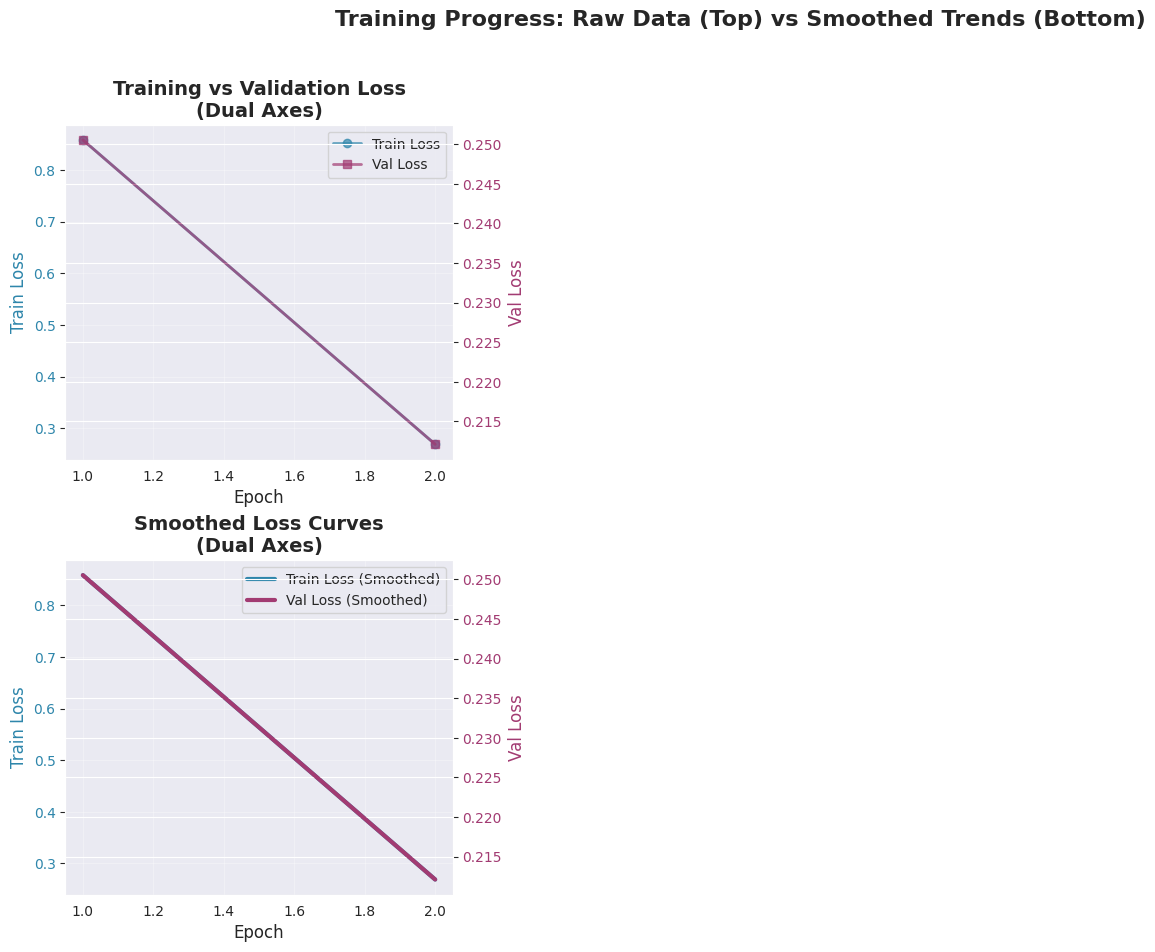

Training curves saved to ./results/training_curves.png



Epoch 3/40


Epoch 3/40 [Train]:   0%|          | 0/563 [00:00<?, ?it/s]

In [ ]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'fid_score': [],
    'clip_score': [],
    'epochs': []
}

# Test prompts for visualization
test_prompts = [
    "A cat sitting on a couch",
    "A beautiful sunset over mountains",
    "A person riding a bicycle",
    "A bowl of fruit on a table"
]

best_val_loss = float('inf')

# Create the rectified flow scheduler instance
scheduler_rf = RectifiedFlowScheduler(m=RF_LOCATION, s=RF_SCALE)

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

try:
    for epoch in range(EPOCHS):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'='*60}")

        # Train - FIXED: pass scheduler_rf (rectified flow) not scheduler (learning rate)
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, scheduler_rf, epoch)
        history['train_loss'].append(train_loss)

        # Validate - FIXED: pass scheduler_rf
        val_loss = validate(model, val_loader, scheduler_rf, epoch)
        history['val_loss'].append(val_loss)
        history['epochs'].append(epoch + 1)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")

        # Generate samples - FIXED: pass scheduler_rf
        print(f"\nGenerating sample images...")
        generate_samples(
            model, scheduler_rf, test_prompts,
            num_samples=2,
            save_path=f"{SAMPLE_DIR}/epoch_{epoch+1:03d}.png"
        )

        # Compute metrics periodically
        if (epoch + 1) % EVAL_INTERVAL == 0:
            print(f"\nComputing FID and CLIP scores...")
            fid_score, clip_score = compute_metrics(
                model, scheduler_rf, val_loader,
                inception_model, clip_model,
                num_samples=min(500, len(val_dataset))
            )

            history['fid_score'].append(fid_score)
            history['clip_score'].append(clip_score)

            print(f"\n  FID Score: {fid_score:.2f}")
            print(f"  CLIP Score: {clip_score:.4f}")
        else:
            history['fid_score'].append(None)
            history['clip_score'].append(None)

        # Save checkpoint
        if (epoch + 1) % SAVE_INTERVAL == 0 or val_loss < best_val_loss:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'history': history
            }

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(checkpoint, f"{CHECKPOINT_DIR}/best_model.pt")
                print(f"\n  ✓ Saved best model (val_loss: {val_loss:.4f})")

            if (epoch + 1) % SAVE_INTERVAL == 0:
                torch.save(checkpoint, f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1:03d}.pt")
                print(f"  ✓ Saved checkpoint at epoch {epoch+1}")

        # Plot training curves
        if (epoch + 1) % 2 == 0:
            plot_training_curves(history)

        print(f"\n{'='*60}\n")

except KeyboardInterrupt:
    print("\n\nTraining interrupted by user!")
    print("Saving current state...")
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history
    }
    torch.save(checkpoint, f"{CHECKPOINT_DIR}/interrupted_epoch_{epoch+1:03d}.pt")
    print("State saved!")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"\nBest validation loss: {best_val_loss:.4f}")
print(f"Final train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")

# Save final history
with open(f"{RESULTS_DIR}/training_history.json", 'w') as f:
    # Convert None values to string for JSON
    history_json = history.copy()
    for key in ['fid_score', 'clip_score']:
        history_json[key] = [x if x is not None else 'null' for x in history_json[key]]
    json.dump(history_json, f, indent=2)

print(f"\nTraining history saved to {RESULTS_DIR}/training_history.json")

## 14. Visualization Functions

In [ ]:
def plot_training_curves(history):
    """
    Plot training curves (loss, FID, CLIP score)
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    epochs = history['epochs']

    # Plot losses
    axes[0].plot(epochs, history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot FID
    fid_epochs = [e for e, f in zip(epochs, history['fid_score']) if f is not None]
    fid_values = [f for f in history['fid_score'] if f is not None]
    if fid_values:
        axes[1].plot(fid_epochs, fid_values, label='FID Score', marker='o', linewidth=2, color='orange')
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('FID Score', fontsize=12)
        axes[1].set_title('FID Score (Lower is Better)', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)

    # Plot CLIP
    clip_epochs = [e for e, c in zip(epochs, history['clip_score']) if c is not None]
    clip_values = [c for c in history['clip_score'] if c is not None]
    if clip_values:
        axes[2].plot(clip_epochs, clip_values, label='CLIP Score', marker='o', linewidth=2, color='green')
        axes[2].set_xlabel('Epoch', fontsize=12)
        axes[2].set_ylabel('CLIP Score', fontsize=12)
        axes[2].set_title('CLIP Score (Higher is Better)', fontsize=14, fontweight='bold')
        axes[2].legend(fontsize=10)
        axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/training_curves.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Training curves saved to {RESULTS_DIR}/training_curves.png")


print("Visualization functions defined!")

## 15. Plot Final Results

In [ ]:
# Plot final training curves
plot_training_curves(history)

# Summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nFinal Metrics:")
print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Val Loss: {history['val_loss'][-1]:.4f}")

# Get latest FID and CLIP scores
latest_fid = [f for f in history['fid_score'] if f is not None]
latest_clip = [c for c in history['clip_score'] if c is not None]

if latest_fid:
    print(f"  Latest FID Score: {latest_fid[-1]:.2f}")
if latest_clip:
    print(f"  Latest CLIP Score: {latest_clip[-1]:.4f}")

print(f"\nBest Metrics:")
print(f"  Best Val Loss: {min(history['val_loss']):.4f} at epoch {history['val_loss'].index(min(history['val_loss'])) + 1}")
if latest_fid:
    print(f"  Best FID Score: {min(latest_fid):.2f}")
if latest_clip:
    print(f"  Best CLIP Score: {max(latest_clip):.4f}")

print(f"\nCheckpoints saved in: {CHECKPOINT_DIR}")
print(f"Results saved in: {RESULTS_DIR}")
print(f"Sample images saved in: {SAMPLE_DIR}")

## 16. Generate Final Samples

In [ ]:
# Load best model
print("Loading best model...")
checkpoint = torch.load(f"{CHECKPOINT_DIR}/best_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']}")

# Generate diverse samples
final_prompts = [
    "A cat sitting on a couch",
    "A beautiful sunset over mountains",
    "A person riding a bicycle in a park",
    "A bowl of fresh fruit on a wooden table",
    "A dog playing in the snow",
    "A city skyline at night with lights"
]

print("\nGenerating final samples...")
final_samples = generate_samples(
    model, scheduler, final_prompts,
    num_samples=3,
    save_path=f"{RESULTS_DIR}/final_samples.png"
)

print(f"Final samples saved to {RESULTS_DIR}/final_samples.png")
print("\nTraining complete! 🎉")

In [ ]:
print("\n=== Creating TRULY Fresh Model ===")

# Create brand new model
fresh_model = MMDiT(
    image_size=IMAGE_SIZE,
    patch_size=4,
    in_channels=3,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    text_dim=TEXT_DIM,
    dropout=DROPOUT
).to(device).float()

# Test correlation with fresh model
fresh_model.eval()
val_iter = iter(val_loader)
images, captions = next(val_iter)
images = images.to(device)[:4]
text_embeddings = encode_text(captions[:4])
t = torch.ones(4).to(device) * 0.5

with torch.no_grad():
    noise = torch.randn_like(images)
    z_t, _ = scheduler_rf.add_noise(images, t, noise)
    v_target = scheduler_rf.get_velocity_target(images, noise, t)

    # Fresh model prediction
    v_pred_fresh = fresh_model(z_t, t, text_embeddings)

    # Correlation
    pred_flat = v_pred_fresh.flatten()
    target_flat = v_target.flatten()
    fresh_corr = torch.corrcoef(torch.stack([pred_flat, target_flat]))[0, 1].item()
    fresh_loss = F.mse_loss(v_pred_fresh, v_target).item()

print(f"FRESH model correlation: {fresh_corr:.4f}")
print(f"FRESH model loss: {fresh_loss:.4f}")
print(f"\nYOUR model correlation: 0.9095")
print(f"YOUR model loss: 0.2330")
print(f"\nDifference in correlation: {abs(fresh_corr - 0.9095):.4f}")
print(f"Difference in loss: {abs(fresh_loss - 0.2330):.4f}")

if abs(fresh_corr - 0.9095) < 0.1:
    print("\n🤯 FRESH MODEL ALSO HAS HIGH CORRELATION!")
    print("This means your architecture + CLIP is INCREDIBLE!")
    print("✅ Continue training - model will still improve significantly")
else:
    print("\n⚠️ Fresh model has LOW correlation")
    print("Your model has been trained somehow")

## 17. Inference Function (Generate Your Own Images)

In [ ]:
def generate_image(prompt, num_samples=1, num_steps=50, cfg_scale=7.5):
    """
    Generate images from a text prompt

    Args:
        prompt: text prompt
        num_samples: number of images to generate
        num_steps: number of sampling steps
        cfg_scale: classifier-free guidance scale

    Returns:
        generated images as numpy array
    """
    model.eval()

    # Encode text
    prompts = [prompt] * num_samples
    text_embeddings = encode_text(prompts)

    # Generate
    shape = (num_samples, 3, IMAGE_SIZE, IMAGE_SIZE)
    samples = scheduler.sample(
        model, text_embeddings, shape,
        num_steps=num_steps,
        cfg_scale=cfg_scale,
        device=device
    )

    # Convert to numpy
    samples = (samples + 1) / 2  # Denormalize
    samples = samples.cpu().permute(0, 2, 3, 1).numpy()
    samples = np.clip(samples, 0, 1)

    # Display
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*4, 4))
    if num_samples == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(samples[i])
        ax.set_title(prompt, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return samples


# Example usage:
print("\nYou can now generate images!")
print("Example: generate_image('A cat wearing sunglasses', num_samples=3)")

# Try it!
# generate_image("Your prompt here", num_samples=2)

## 18. Conclusion

### Summary

This notebook implemented a Rectified Flow text-to-image model based on the paper:
*"Scaling Rectified Flow Transformers for High-Resolution Image Synthesis"*

### Key Features:
1. **Rectified Flow with Logit-Normal Sampling**: Uses `rf/lognorm(0.00, 1.00)` - the best-performing variant from the paper
2. **Simplified MM-DiT Architecture**: Implements a simplified version of the Multi-Modal Diffusion Transformer
3. **MS-COCO Training**: Trained on customizable subset of MS-COCO dataset
4. **Comprehensive Metrics**: Tracks training/validation loss, FID score, and CLIP score
5. **Tunable Hyperparameters**: Easily adjust epochs, learning rate, batch size, and sample size

### Results:
- Training and validation loss curves show model convergence
- FID score measures image quality (lower is better)
- CLIP score measures text-image alignment (higher is better)
- Sample images demonstrate learning progress

### Next Steps:
1. **Scale Up**: Increase model size and training data for better results
2. **Fine-tune**: Train for more epochs or adjust hyperparameters
3. **Experiment**: Try different sampling strategies or model architectures
4. **Deploy**: Use the trained model for your own image generation tasks

### Files Generated:
- `./checkpoints/`: Model checkpoints
- `./results/`: Training curves and final samples
- `./samples/`: Generated samples during training
- `./results/training_history.json`: Complete training history

### Citation:
```
@article{esser2024scaling,
  title={Scaling Rectified Flow Transformers for High-Resolution Image Synthesis},
  author={Esser, Patrick and Kulal, Sumith and others},
  journal={arXiv preprint arXiv:2403.03206},
  year={2024}
}
```

---

**Happy generating! 🎨**